In [4]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

%matplotlib inline

In [5]:
with open('/Volumes/thesis-data/dtype_dict.json', 'r') as d:
    dtypes = json.load(d)

In [6]:
main = pd.read_csv(
    '/Volumes/thesis-data/cwmtaf.csv',
    dtype=dtypes,
    parse_dates=['ADMDATE', 'DISCDATE', 'PERIOD']
)

In [20]:
class Distribution(object):

    def __init__(self, dist_names=None):

        if not dist_names:
            raise ValueError('Must specify which distributions to fit.')

        self.dist_names = dist_names
        self.dist_results = []
        self.params = {}

        self.name = ''
        self.p_value = 0
        self.param = None
        
        self.fitted = False
        
        
    def fit(self, y):

        self.dist_results = []
        self.params = {}

        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)

            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param)
            self.dist_results.append((dist_name, p))

        #select the best fitted distribution
        sel_dist, p = (max(self.dist_results, key=lambda item: item[1]))
        #store the name of the best fit and its p value
        self.name = sel_dist
        self.p_value = p

        self.fitted = True
        return self.name, self.p_value
    
    def sample(self, n=1):

        if self.fitted:
            dist_name = self.name
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)

        else:
            raise ValueError('Must first run the Fit method.')

    def plot(self, y):

        x = self.sample(n=len(y))
        plt.hist(x, alpha=0.5, bins=100, label='Fitted')
        plt.hist(y, alpha=0.5, bins=100, label='Actual')
        plt.legend(loc='upper right')

In [21]:
dist = Distribution(['expon', 'norm', 'lognorm'])

data = main.groupby('SPELL_ID')['NetCost'].sum()
name, p = dist.fit(data)

print(dist.params[name])

(16.611899999998805, 1902.485267747899)


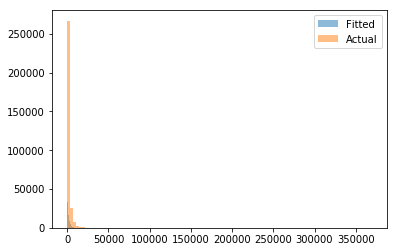

In [22]:
dist.plot(data)